# Research Question 3

Can we classify whether a store’s weekly sales will be above or below average?

Hypothesis: Weekly sales can be reliably categorized as “high” or “low” using classification models with predictors like fuel price, CPI, unemployment, and holiday flags.

## Data Ingestion

In [4631]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# matplotlib.pyplot for data plots
import matplotlib.pyplot as plt

import seaborn as sns

In [4632]:
# Load dataset
df = pd.read_csv('../Data/Walmart_Sales.csv')

In [4633]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [4634]:
df.shape

(6435, 8)

In [4635]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [4636]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [4637]:
df.duplicated().sum()

0

In [4638]:
df.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3216,23,10-06-2011,1447028.06,0,65.23,3.924,134.942548,4.781
5577,40,05-02-2010,1001943.80,0,14.48,2.788,131.527903,5.892
3943,28,02-09-2011,1468871.49,0,93.66,3.798,129.325936,13.503
5531,39,16-12-2011,1991824.05,0,58.58,3.159,217.878134,7.716
6330,45,29-10-2010,732859.76,0,61.30,2.921,182.901117,8.724


### Data Cleaning

In [4639]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

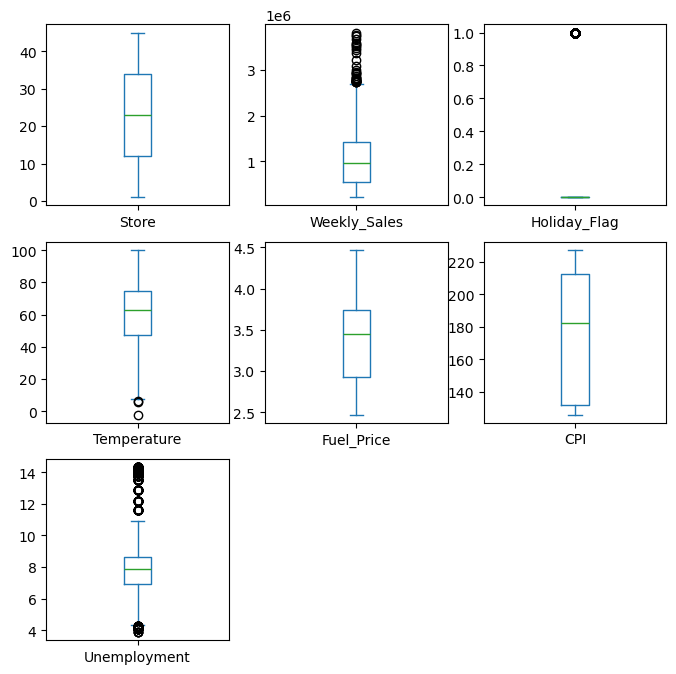

In [4640]:
# Draw box-whisker plots
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(8, 8), sharex=False, sharey=False)
plt.show()

In [4641]:
import pandas as pd

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outlier_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    outliers = df[~non_outlier_mask]
    df_clean = df[non_outlier_mask]

    print(f"Number of outliers to be removed from '{column}': {len(outliers)}")
    print(f"Remaining rows: {len(df_clean)}")

    return df


In [4642]:
df = remove_outliers(df, 'Weekly_Sales')
df = remove_outliers(df, 'Temperature')
df = remove_outliers(df, 'Unemployment')

Number of outliers to be removed from 'Weekly_Sales': 34
Remaining rows: 6401
Number of outliers to be removed from 'Temperature': 3
Remaining rows: 6432
Number of outliers to be removed from 'Unemployment': 481
Remaining rows: 5954


In [4643]:
df.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3942,28,2011-08-26,1166479.51,0,94.61,3.740,129.283258,13.503
566,4,2012-09-21,2119438.53,0,68.97,3.721,131.010333,4.077
5771,41,2011-01-28,1026439.93,0,32.23,3.008,191.667891,7.241
5974,42,2012-03-23,561226.38,0,56.54,4.288,130.896645,7.545
1735,13,2010-06-18,2003435.31,0,58.41,2.819,126.114000,8.107


In [4644]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

# Correcting the date format
#df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
#df['Date'] = df['Date'].map(lambda x: x.toordinal())
#df['Year'] = df['Date'].dt.year
#df['Month'] = df['Date'].dt.month
#df['Quarter'] = df['Date'].dt.quarter
#df['Week'] = df['Date'].dt.isocalendar().week

#df.drop(['Date'], axis=1, inplace=True)

#df['Date'] = labelEncoder.fit_transform(df['Date'])

## Feature Engineering

In [4645]:
# Create the target column: 1 if weekly sales are above average, else 0
mean_sales = df['Weekly_Sales'].mean()
df['High_Sales'] = (df['Weekly_Sales'] > mean_sales).astype(int)

df.drop(['Weekly_Sales'], axis=1, inplace=True)

## Feature Selection

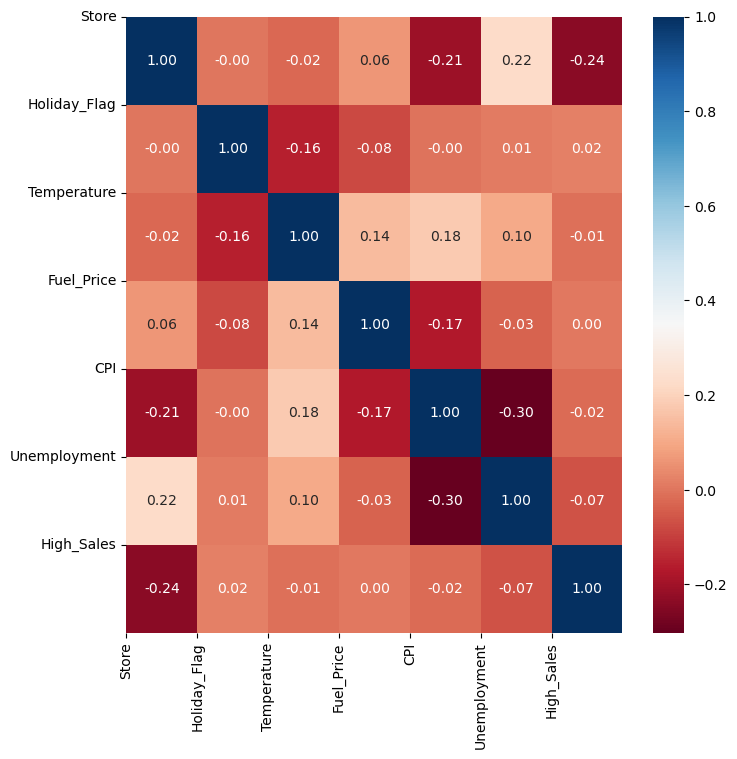

In [4646]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
corr = df[numeric_columns].corr(method='pearson')
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [4647]:
df = df.drop(['Date'], axis=1)

In [4648]:
df.sample(5)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,High_Sales
4462,32,0,74.95,2.731,190.328492,9.017,1
5079,36,0,84.71,3.440,214.024556,8.177,0
5298,38,0,60.06,3.083,126.605064,13.975,0
5394,38,0,50.43,3.675,130.314452,12.187,0
260,2,0,76.73,3.749,221.309517,6.891,1


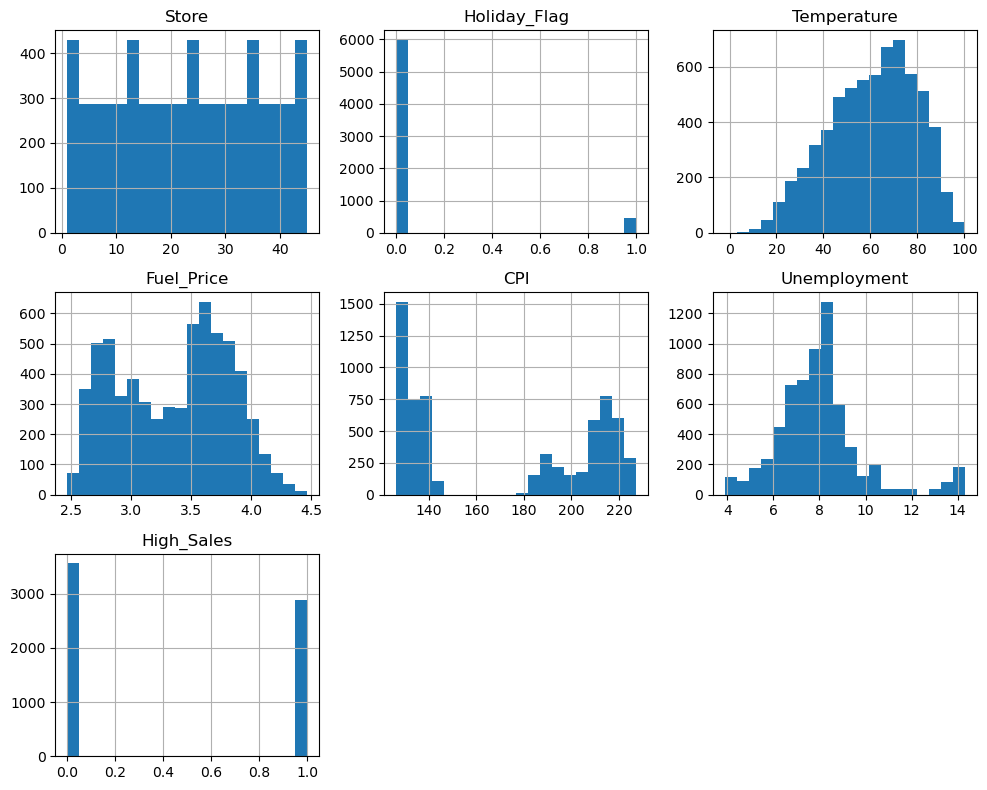

In [4668]:
df.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

## Scaling

In [4650]:
X = df.drop('High_Sales', axis=1)
y = df['High_Sales']

In [4651]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feature_labels = X.columns.tolist()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=feature_labels)
X.sample(5)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
578,-1.385983,-0.274204,-0.282147,-1.391349,1.021316,-0.764046
2915,-0.153998,-0.274204,0.032869,-0.639689,1.057387,0.015380
4079,0.461994,-0.274204,0.788149,1.020500,-0.909564,0.993661
2841,-0.230997,-0.274204,0.859176,0.447495,1.093357,-0.458566
6162,1.616980,-0.274204,-0.880732,-0.894599,-1.150810,-0.014475


## Training

In [4652]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

Through experimentation it was found that the best to split the set into 0.2% for test.

In [4653]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [4654]:
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (5148, 6)
Shape of X_test:  (1287, 6)
Shape of y_train:  (5148,)
Shape of y_test:  (1287,)


Through experimentation it was found that a max_depth of 12 gave the best results.

In [4655]:
decisionTreeClassifier = DecisionTreeClassifier(max_depth=12, random_state=42)
decisionTreeClassifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [4656]:
y_pred = decisionTreeClassifier.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print(classification_report(y_test, y_pred))

Accuracy: 94.64%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       702
           1       0.93      0.96      0.94       585

    accuracy                           0.95      1287
   macro avg       0.95      0.95      0.95      1287
weighted avg       0.95      0.95      0.95      1287



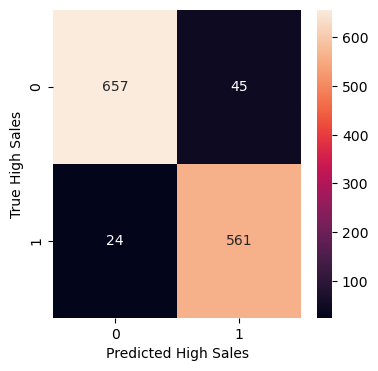

In [4657]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

In [4658]:
from sklearn.ensemble import RandomForestClassifier

randomForestClassifier = RandomForestClassifier(random_state=42)
randomForestClassifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [4659]:
y_pred = randomForestClassifier.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print(classification_report(y_test, y_pred))

Accuracy: 96.58%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       702
           1       0.97      0.96      0.96       585

    accuracy                           0.97      1287
   macro avg       0.97      0.97      0.97      1287
weighted avg       0.97      0.97      0.97      1287



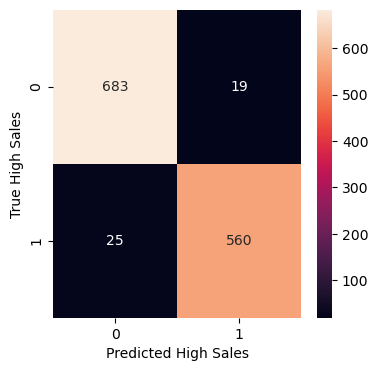

In [4660]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

In [4661]:
from sklearn.naive_bayes import GaussianNB

bayers = GaussianNB()
bayers.fit(X_train, y_train)

GaussianNB()

In [4662]:
y_pred = bayers.predict(X_test)
y_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy: {0:.2f}%".format(y_acc_score * 100))
print("Score: {0:.2f}%".format(bayers.score(X_test, y_test) * 100))
print(classification_report(y_test, y_pred))

Accuracy: 59.13%
Score: 59.13%
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       702
           1       0.55      0.56      0.55       585

    accuracy                           0.59      1287
   macro avg       0.59      0.59      0.59      1287
weighted avg       0.59      0.59      0.59      1287



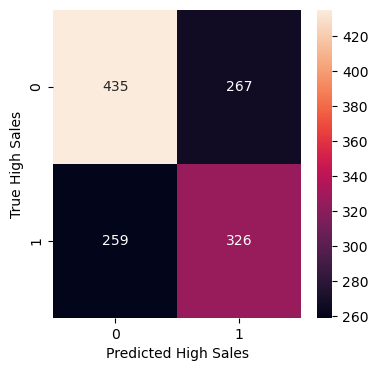

In [4663]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted High Sales")
plt.ylabel("True High Sales")
plt.show()

## Validation

In [4664]:
X_test

array([[-0.38499525, -0.27420425, -0.99079799, -1.20615705, -1.01119946,
         0.64126669],
       [ 0.07699905, -0.27420425,  0.4454804 ,  1.31898521, -0.92273838,
         0.11347472],
       [-1.61698006, -0.27420425,  0.28227927,  0.02918002,  1.16245339,
        -0.29756328],
       ...,
       [ 1.69397911, -0.27420425, -1.80843024, -1.25191028,  0.26154613,
         0.52931082],
       [-1.61698006, -0.27420425,  0.14130819, -1.3935274 ,  0.98851033,
         0.10707724],
       [-0.4619943 , -0.27420425, -1.97651114, -0.28019893, -1.10062572,
        -0.60410912]])

In [4665]:
y_pred = decisionTreeClassifier.predict(X_test)
y_pred.shape

(1287,)

In [4666]:
y_pred[:50]

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0])

In [4667]:
y_test[:50]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0])